<a href="https://colab.research.google.com/github/jarminett/Statistical_Learning_II/blob/main/Practica02/Practica02_0710082.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UNIVERSIDAD GALILEO** \\
Instituto de Investigación de Operaciones \\
Posgrado en Análisis y Predicción de Datos \\
Luis Florian, 0710082, sección U \\


**Detección de Anomalías**

Usando el dataset de estaturas aplicar detección de anomalías

Usar como training-set la primera pestaña de "normales" (y = 0 o sin anomalías)

La segunda pestaña "valtest(normales)" contiene datos normales (y = 0 / sin anomalías)
* Usar la mitad para cross-validation
* Usar la mitad para testing

La tercera pestaña "valtest(anomalías)" contiene anomalías (y = 1)
* Usar la mitad para cross-validation
* Usar la mitad para testing


**Reducción de Dimensionalidad**

Usando el dataset de "fashion MNIST" realizar:
* PCA sin sci-kit learn para reducir a 2 dimensiones. Anotar la cantidad de varianza preservada.

### **Importing Libraries**

## **Detección de Anomalías**

In [180]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
from tensorflow import keras
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from keras.datasets import fashion_mnist

### **Loading Data**

In [54]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [171]:
training = pd.read_csv("/content/drive/MyDrive/MyNotebooks/Data Science Msc/Statistical Learning II/Lab02/estaturas_normales.csv")
anomalias = pd.read_csv("/content/drive/MyDrive/MyNotebooks/Data Science Msc/Statistical Learning II/Lab02/valtest-anomalias.csv")
normales = pd.read_csv("/content/drive/MyDrive/MyNotebooks/Data Science Msc/Statistical Learning II/Lab02/valtest-normales.csv")
training.head()

,Estatura,Edad
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


In [173]:
validationSet = pd.concat([normales.loc[:(len(normales)/2)-1,], anomalias.loc[:(len(anomalias)/2)-1,]], ignore_index = True)
testSet = pd.concat([normales.loc[len(normales)/2:,], anomalias.loc[len(anomalias)/2:,]], ignore_index = True)

,Estatura,Edad
0,1.82,30.0
1,1.76,32.0
2,1.79,31.0
3,1.61,31.0
4,0.15,250.0
5,150.00,14.0


### **Plot Training Data**

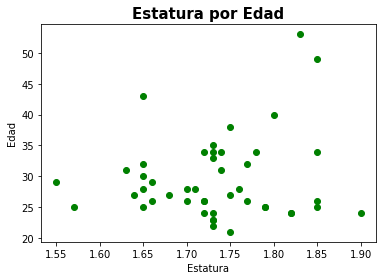

In [57]:
font = {'family': 'DejaVu Sans',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

plt.scatter(training.iloc[:,0], training.iloc[:,1], c="green")
plt.xlabel("Estatura")
plt.ylabel("Edad")
plt.title("Estatura por Edad", fontdict=font)
plt.show()

In [156]:
def multivariateGaussian(dataset, mu, sigma):
  gaussian = multivariate_normal(mean=mu, cov=sigma)  
  return gaussian.pdf(dataset)

def getGaussian(dataset):
  mu = np.mean(dataset, axis=0)
  sigma = np.cov(dataset.T)
  return mu, sigma

def getEpsilon(probs, true_anomaly):
  myepsilon = 0
  f1Score = 0
  current_f1Score = 0

  step_size = (max(probs) - min(probs)) / 1000
  epsilons_list = np.arange(min(probs), max(probs), step_size)
  print(np.nditer(epsilons_list))

  for epsilon in np.nditer(epsilons_list):
    predictions = (probs < epsilon)
    current_f1Score = f1_score(true_anomaly.iloc[:,2], predictions, average = "binary")
    
    if (current_f1Score > f1Score):
      f1Score = current_f1Score 
      myepsilon = epsilon
      
  return f1Score, myepsilon

In [176]:
def DetectAnomalies(probs, epsilon, datasett):
  dataset = datasett.copy() # para evitar que se hagan cambios en dataset original
  anomalies = []
  for prob in probs:      
    if prob < epsilon:
      anomalies.append("YES")
    else:
      anomalies.append("NO")

  dataset['Anomalía'] = anomalies

  return dataset

In [177]:
mu, sigma = getGaussian(training)
probs = multivariateGaussian(training, mu, sigma)

#Validacion
probs_validacion = multivariateGaussian(validationSet, mu, sigma)
probs_validacion

validationSetTrueAnomaly = validationSet.copy()
validationSetTrueAnomaly['Anomalia'] = [False, False, False, False,  True,  True]

#The best hyperparameters
f1, eps = getEpsilon(probs_validacion, validationSetTrueAnomaly)
eps

array(0.00018691)

### **Detección de Anomalías**
Esta parte se realizará con el dataset de validación.

In [178]:
anomaly = DetectAnomalies(probs_validacion, eps, validationSet)
anomaly

,Estatura,Edad,Anomalía
0,1.82,25.0,NO
1,1.80,27.0,NO
2,1.60,31.0,NO
3,1.60,35.0,NO
4,0.25,2.4,YES
5,175.10,2.5,YES


A continuación se presenta otra detección de anomalías.  Esta vez, utilizando el data set de testing.

In [179]:
probs_test = multivariateGaussian(testSet, mu, sigma)
anomalyTest = DetectAnomalies(probs_test, eps, testSet)
anomalyTest


,Estatura,Edad,Anomalía
0,1.82,30.0,NO
1,1.76,32.0,NO
2,1.79,31.0,NO
3,1.61,31.0,NO
4,0.15,250.0,YES
5,150.00,14.0,YES


### **Conclusiones**
Como se observa, tanto para validation como para testing el resultado tiene sentido.  Los outliers son detectados como Anomalías.